In [80]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from tensorflow.keras.optimizers import Adam


In [81]:
# Load dataset
data = pd.read_csv('Jowar.csv')
crop = 'Jowar'


In [82]:
data.describe()

,Sl no.,Min Price (Rs./Quintal),Max Price (Rs./Quintal),Modal Price (Rs./Quintal)
count,20728.000000,20728.000000,20728.000000,20728.000000
mean,3623.633732,2018.274170,2810.030249,2432.124421
std,3014.063893,750.236597,1066.431116,821.637493
min,1.000000,18.000000,20.000000,20.000000
25%,1037.000000,1590.000000,2050.000000,1850.000000
50%,2708.500000,1751.000000,2660.000000,2210.000000
75%,5528.250000,2300.000000,3450.000000,2840.000000
max,10710.000000,25600.000000,41000.000000,34000.000000


In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20728 entries, 0 to 20727
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Sl no.                     20728 non-null  int64 
 1   District_Name              20728 non-null  object
 2   Market_Name                20728 non-null  object
 3   Commodity                  20728 non-null  object
 4   Variety                    20728 non-null  object
 5   Grade                      20728 non-null  object
 6   Min Price (Rs./Quintal)    20728 non-null  int64 
 7   Max Price (Rs./Quintal)    20728 non-null  int64 
 8   Modal Price (Rs./Quintal)  20728 non-null  int64 
 9   Price Date                 20728 non-null  object
dtypes: int64(4), object(6)
memory usage: 1.6+ MB


In [84]:
MN = list(data.Market_Name.unique())
len(MN)

30

In [85]:
for i in range(len(MN)):
    data.Market_Name.replace({MN[i]:i},inplace=True)
data.Market_Name

0         0
1         0
2         1
3         1
4         1
         ..
20723    29
20724    29
20725    29
20726    29
20727    29
Name: Market_Name, Length: 20728, dtype: int64

In [86]:
data = data.drop(['Sl no.', 'District_Name', 'Commodity', 'Grade', 'Variety'], axis = 1)


In [87]:
data_dup = data
data_dup = data_dup.drop(['Price Date'], axis = 1)

<Axes: >

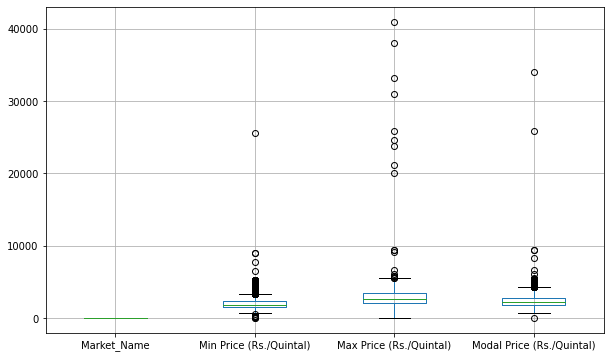

In [88]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
data.boxplot()

In [89]:
from numpy import where
def imp_iqr(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    IQR = q3 -q1 
    upper = data[~(data>(q3+1.5*IQR))].max()
    lower = data[~(data<(q1-1.5*IQR))].min()
    feature = where(data>upper, data.mean(), where(data<lower, data.mean(), data))
    return feature

for col in data_dup.columns:
    data[col] = imp_iqr(data_dup[col])


<Axes: >

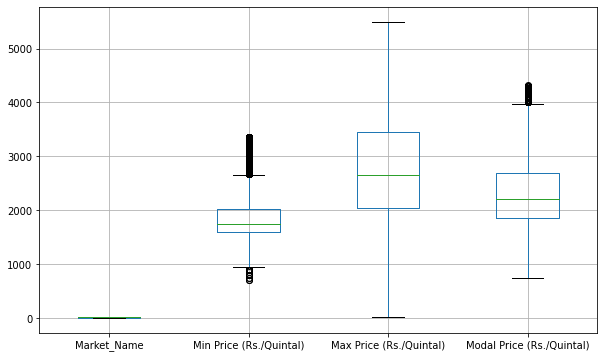

In [90]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
data.boxplot()

In [91]:
# Filter data for a specific crop variety
#crop_data = data[data['Commodity'] == 'Ginger']  # Replace 'Cotton' with the desired crop variety

# Select relevant columns and convert 'Price Date' to datetime
crop_data = data[['Price Date', 'Market_Name', 'Min Price (Rs./Quintal)', 'Max Price (Rs./Quintal)', 'Modal Price (Rs./Quintal)']]
crop_data['Price Date'] = pd.to_datetime(crop_data['Price Date'])

# Sort by 'Price Date'
crop_data = crop_data.sort_values(by='Price Date')

In [92]:
crop_data

,Price Date,Market_Name,Min Price (Rs./Quintal),Max Price (Rs./Quintal),Modal Price (Rs./Quintal)
6197,2012-01-01,12.0,2611.00000,2611.0,2611.000000
20727,2012-01-02,29.0,2810.00000,3500.0,3090.000000
7850,2012-01-02,14.0,1050.00000,2000.0,1525.000000
16252,2012-01-02,23.0,3150.00000,3500.0,3200.000000
17723,2012-01-02,25.0,2600.00000,3401.0,3000.000000
...,...,...,...,...,...
7851,2022-12-30,15.0,2840.00000,3200.0,3060.000000
12011,2022-12-30,20.0,2018.27417,5300.0,2432.124421
12010,2022-12-31,20.0,2018.27417,4000.0,4000.000000
2978,2022-12-31,9.0,2018.27417,5400.0,2432.124421


In [93]:
# Feature engineering - create sequences for LSTM
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        targets.append(data[i+sequence_length])
    return np.array(sequences), np.array(targets)

sequence_length = 10  # Define the sequence length for LSTM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(crop_data[['Min Price (Rs./Quintal)', 'Max Price (Rs./Quintal)', 'Modal Price (Rs./Quintal)']])

In [94]:
# Create sequences and targets
sequences, targets = create_sequences(scaled_data, sequence_length)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.3, random_state=42)


In [95]:
# Build LSTM model
model = Sequential()
model.add(LSTM(45, activation='softmax', input_shape=(sequence_length, 3), return_sequences='True'))
model.add(LSTM(10, activation='softmax'))
model.add(Dense(3))  # Output layer with 3 neurons for Min Price, Max Price, and Modal Price
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse',metrics=['accuracy'])  # Mean Squared Error loss function

# Train the model
his = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
454/454 [==============================] - 6s 8ms/step - loss: 0.0304 - accuracy: 0.5398 - val_loss: 0.0221 - val_accuracy: 0.5833
Epoch 2/50
454/454 [==============================] - 4s 8ms/step - loss: 0.0214 - accuracy: 0.5466 - val_loss: 0.0219 - val_accuracy: 0.5359
Epoch 3/50
454/454 [==============================] - 4s 8ms/step - loss: 0.0213 - accuracy: 0.5499 - val_loss: 0.0220 - val_accuracy: 0.5396
Epoch 4/50
454/454 [==============================] - 4s 8ms/step - loss: 0.0213 - accuracy: 0.5490 - val_loss: 0.0216 - val_accuracy: 0.5830
Epoch 5/50
454/454 [==============================] - 4s 8ms/step - loss: 0.0213 - accuracy: 0.5544 - val_loss: 0.0214 - val_accuracy: 0.5367
Epoch 6/50
454/454 [==============================] - 4s 8ms/step - loss: 0.0212 - accuracy: 0.5512 - val_loss: 0.0215 - val_accuracy: 0.5532
Epoch 7/50
454/454 [==============================] - 4s 8ms/step - loss: 0.0212 - accuracy: 0.5553 - val_loss: 0.0214 - val_accuracy: 0.5384
Epoch 

In [96]:
print(his.history['accuracy'])

[0.5397875905036926, 0.5466142892837524, 0.5498551726341248, 0.5490277409553528, 0.5544062852859497, 0.5512343049049377, 0.5553027391433716, 0.5515791177749634, 0.5533030033111572, 0.554957926273346, 0.5521997213363647, 0.5556474924087524, 0.5541304349899292, 0.5565439462661743, 0.5534409284591675, 0.5551648139953613, 0.5576472282409668, 0.5519928336143494, 0.5541304349899292, 0.5566818118095398, 0.5542683601379395, 0.5601296424865723, 0.5566818118095398, 0.5553717017173767, 0.5564749836921692, 0.5566818118095398, 0.5530961155891418, 0.555923342704773, 0.5574403405189514, 0.558198869228363, 0.5592331886291504, 0.5560612082481384, 0.5561991333961487, 0.5573713779449463, 0.5560612082481384, 0.5551648139953613, 0.557785153388977, 0.5566129088401794, 0.5566129088401794, 0.5573713779449463, 0.5584747195243835, 0.5544752478599548, 0.5564060211181641, 0.555923342704773, 0.5556474924087524, 0.5590263605117798, 0.5579919815063477, 0.5562680959701538, 0.5562680959701538, 0.5586815476417542]


In [97]:
import matplotlib.pyplot as plt
def plot_learning_curve(training_loss, validation_loss, title):
    epochs = range(1, len(training_loss) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, training_loss, 'b', label='Training Loss')
    plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
    plt.title(title + ' Learning Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


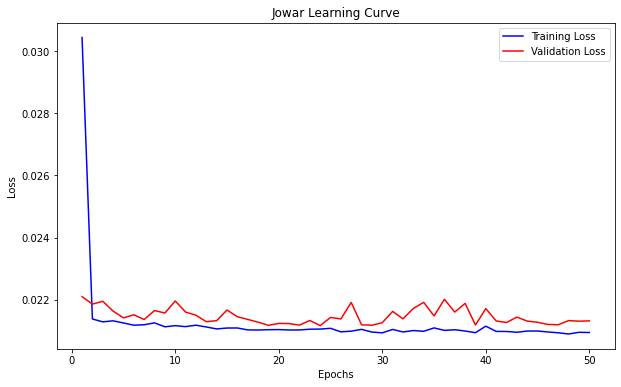

In [98]:
training_loss = his.history['loss']
validation_loss = his.history['val_loss']
title = crop
plot_learning_curve(training_loss, validation_loss, title)

In [99]:
# Evaluate the model on the test set
test_predictions = model.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions)  # Inverse transform to get actual prices
y_test = scaler.inverse_transform(y_test)

In [100]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, test_predictions)
mse = mean_squared_error(y_test, test_predictions)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 456.66415038371525
Root Mean Squared Error (RMSE): 591.3886952019318


In [101]:
for i in range(len(y_test)):
    print(y_test[i], test_predictions[i])

[1600. 1700. 1700.] [2171.909  3291.5068 2747.4978]
[1600. 2075. 1750.] [1854.6978 2768.6917 2330.7285]
[3062. 3235. 3100.] [2427.6218 3604.8213 3067.8599]
[1700. 3700. 2600.] [1859.8466 2780.4524 2339.531 ]
[1775. 1775. 1775.] [1805.3832 2629.1003 2253.4858]
[1550. 1970. 1720.] [1596.4742 2264.253  1960.4049]
[3100. 3800. 3200.] [2101.024  3197.6667 2660.4104]
[1380. 1740. 1650.] [1734.0099 2487.4368 2148.2107]
[1825. 1825. 1825.] [1907.9432 2893.6968 2407.7534]
[2050. 2600. 2230.] [1766.4578 2548.3774 2194.2786]
[1600. 2740. 2200.] [1470.44   2083.3567 1794.3439]
[1550. 2900. 2000.] [1733.2992 2486.4941 2147.1436]
[1700. 2025. 1800.] [1720.7894 2455.473  2128.6643]
[2018.2741702  5000.         2432.12442107] [2455.6199 3639.7776 3102.7637]
[1900. 4000. 2500.] [2302.4504 3455.003  2911.612 ]
[1500. 2300. 1700.] [1976.9125 3011.4358 2500.0134]
[2018.2741702  4800.         2432.12442107] [2061.9038 3131.709  2608.3723]
[1980. 2260. 2130.] [1576.2848 2232.0815 1933.9043]
[2550. 2700. 262

In [102]:
""" results_df = pd.DataFrame({
    'Actual_Min_Price': y_test[:, 0],      # Assuming Min Price is the first column in y_test
    'Actual_Max_Price': y_test[:, 1],      # Assuming Max Price is the second column in y_test
    'Actual_Modal_Price': y_test[:, 2],    # Assuming Modal Price is the third column in y_test
    'Predicted_Min_Price': test_predictions[:, 0],
    'Predicted_Max_Price': test_predictions[:, 1],
    'Predicted_Modal_Price': test_predictions[:, 2]
})

# Save the DataFrame to a CSV file
results_df.to_csv(f'{crop}_res.csv', index=False) """

" results_df = pd.DataFrame({\n    'Actual_Min_Price': y_test[:, 0],      # Assuming Min Price is the first column in y_test\n    'Actual_Max_Price': y_test[:, 1],      # Assuming Max Price is the second column in y_test\n    'Actual_Modal_Price': y_test[:, 2],    # Assuming Modal Price is the third column in y_test\n    'Predicted_Min_Price': test_predictions[:, 0],\n    'Predicted_Max_Price': test_predictions[:, 1],\n    'Predicted_Modal_Price': test_predictions[:, 2]\n})\n\n# Save the DataFrame to a CSV file\nresults_df.to_csv(f'{crop}_res.csv', index=False) "

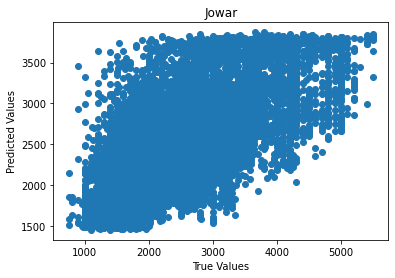

In [103]:
import matplotlib.pyplot as plt

plt.scatter(y_test, test_predictions)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title(crop)
plt.show()

In [104]:
# Predicting future prices (adjust this based on your requirement)
future_data = scaled_data[-sequence_length:]  # Take the last sequence from the dataset
future_sequence = future_data.reshape((1, sequence_length, 3))  # Reshape for prediction
future_prediction = model.predict(future_sequence)
future_prediction = scaler.inverse_transform(future_prediction)  # Inverse transform to get actual prices

print("Predicted Min Price:", future_prediction[0][0])
print("Predicted Max Price:", future_prediction[0][1])
print("Predicted Modal Price:", future_prediction[0][2])

Predicted Min Price: 2537.8003
Predicted Max Price: 3736.0933
Predicted Modal Price: 3204.1885


In [110]:
#model.save(f'{crop}_mn.h5')

In [106]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd

# Assuming crop_data is your DataFrame
# Extract the most recent timestamp
most_recent_timestamp = pd.to_datetime(crop_data['Price Date'].max())

# Number of quarters to predict into the future
num_quarters = 8  # Adjust as needed

# Function to generate future timestamps quarterly
def generate_quarterly_timestamps(start_date, num_quarters):
    timestamps = [start_date + timedelta(days=(i * 90)) for i in range(1, num_quarters + 1)]
    return timestamps

# Function to predict future prices based on historical data for a specific market
def predict_future_prices_for_market(model, scaler, historical_data, market_name, timestamps):
    num_features = model.input_shape[2]
    sequence_length = model.input_shape[1]

    # Check the column names and adjust accordingly
    feature_columns = ['Min Price (Rs./Quintal)', 'Max Price (Rs./Quintal)', 'Modal Price (Rs./Quintal)']

    # Filter historical data for the specific market
    market_data = historical_data[historical_data['Market_Name'] == market_name]

    # Scale the historical data
    scaled_data = scaler.transform(market_data[feature_columns])

    # Initialize an array to store predicted prices
    predicted_prices = np.zeros((len(timestamps), num_features))

    for i in range(len(timestamps)):
        # Use the last sequence_length data points for initialization
        sequence = scaled_data[-sequence_length:]

        # Ensure sequence length is consistent
        if len(sequence) < sequence_length:
            # Pad with zeros if sequence is shorter than expected
            sequence = np.pad(sequence, ((0, sequence_length - len(sequence)), (0, 0)))

        # Reshape for LSTM sequence
        reshaped_sequence = sequence.reshape((1, sequence_length, num_features))

        # Make prediction
        prediction = model.predict(reshaped_sequence)

        # Inverse transform prediction
        inverse_prediction = scaler.inverse_transform(prediction)

        # Store the predicted prices
        predicted_prices[i] = inverse_prediction.flatten()

        # Append the predicted prices to the scaled data for the next iteration
        scaled_data = np.vstack([scaled_data, inverse_prediction])

    return predicted_prices

# Extract historical data (excluding the most recent data point)
historical_data = crop_data.iloc[:-1]

# Get unique market names
market_names = historical_data['Market_Name'].unique()

# Example usage for predicting future prices for each market
all_predictions = []

for market_name in market_names:
    # Generate quarterly timestamps for the market
    quarterly_timestamps = generate_quarterly_timestamps(most_recent_timestamp, num_quarters)
    
    # Predict future prices for the market
    future_prices = predict_future_prices_for_market(model, scaler, historical_data, market_name, quarterly_timestamps)

    # Create a dataframe to store the results
    columns = ['Predicted Min Price', 'Predicted Max Price', 'Predicted Modal Price']
    future_prices_df = pd.DataFrame(future_prices, columns=columns)
    future_prices_df['Timestamp'] = quarterly_timestamps
    future_prices_df['Market_Name'] = market_name
    future_prices_df = future_prices_df[['Timestamp', 'Market_Name'] + columns]

    # Append predictions for the current market to the overall list
    all_predictions.append(future_prices_df)

# Concatenate all predictions into a single DataFrame
all_predictions_df = pd.concat(all_predictions, ignore_index=True)

# Display the final predicted prices
print(all_predictions_df)



     Timestamp  Market_Name  Predicted Min Price  Predicted Max Price  \
0   2023-03-31         12.0          2306.368896          3455.492188   
1   2023-06-29         12.0          2358.024170          3523.491455   
2   2023-09-27         12.0          2434.039551          3615.475586   
3   2023-12-26         12.0          2479.234619          3669.639893   
4   2024-03-25         12.0          2468.681396          3657.411377   
..         ...          ...                  ...                  ...   
235 2023-12-26         11.0          1869.095825          2796.489258   
236 2024-03-25         11.0          1950.297974          2935.947998   
237 2024-06-23         11.0          2036.022461          3054.879639   
238 2024-09-21         11.0          2136.104980          3183.276611   
239 2024-12-20         11.0          2210.688232          3236.804932   

     Predicted Modal Price  
0              2916.360352  
1              2981.534668  
2              3076.100830  
3      

In [107]:
all_predictions_df

,Timestamp,Market_Name,Predicted Min Price,Predicted Max Price,Predicted Modal Price
0,2023-03-31,12.0,2306.368896,3455.492188,2916.360352
1,2023-06-29,12.0,2358.024170,3523.491455,2981.534668
2,2023-09-27,12.0,2434.039551,3615.475586,3076.100830
3,2023-12-26,12.0,2479.234619,3669.639893,3132.131348
4,2024-03-25,12.0,2468.681396,3657.411377,3119.006348
...,...,...,...,...,...
235,2023-12-26,11.0,1869.095825,2796.489258,2349.462402
236,2024-03-25,11.0,1950.297974,2935.947998,2458.929199
237,2024-06-23,11.0,2036.022461,3054.879639,2568.821777
238,2024-09-21,11.0,2136.104980,3183.276611,2694.323730


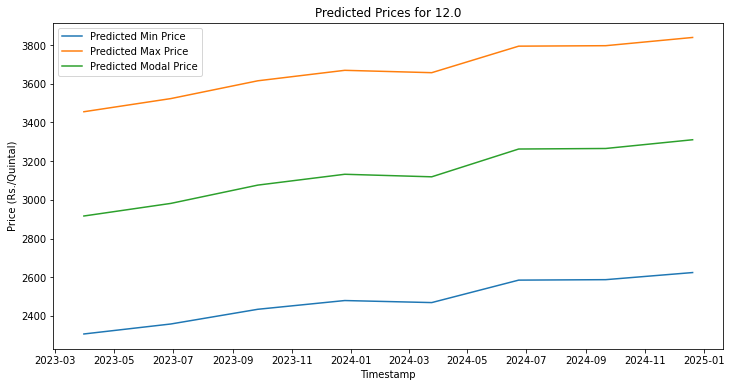

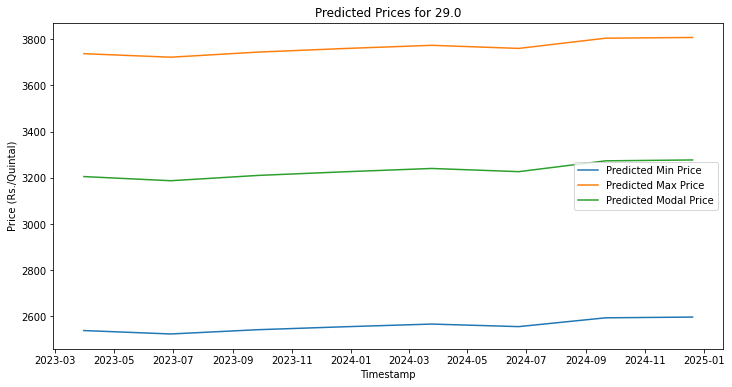

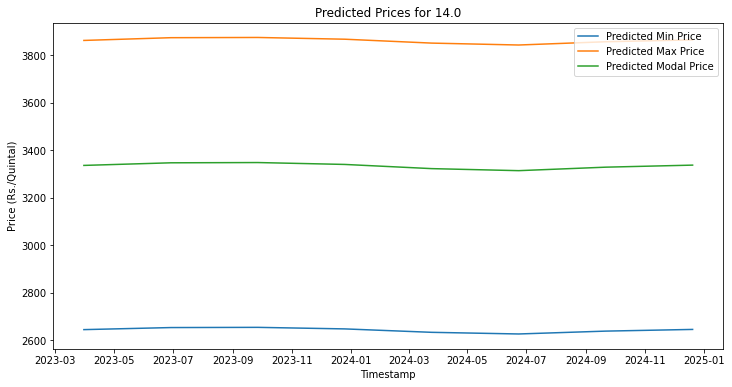

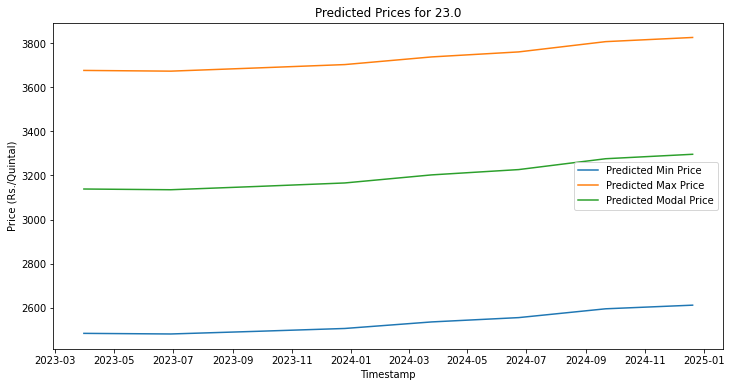

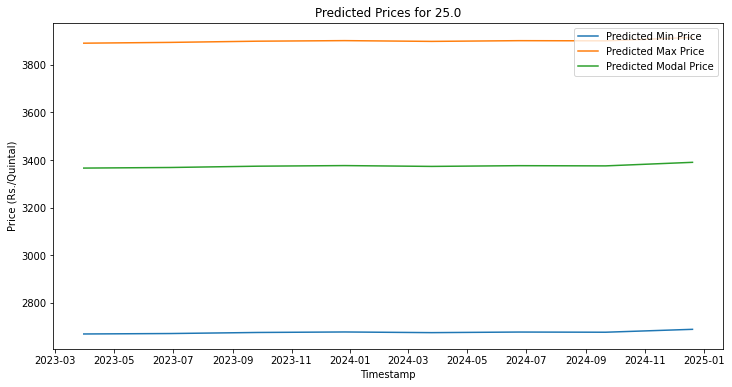

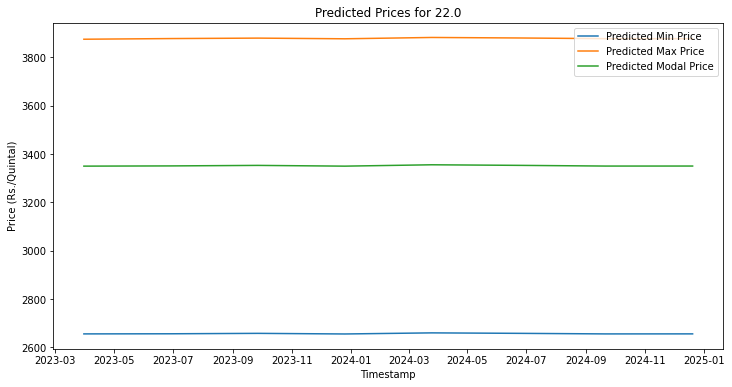

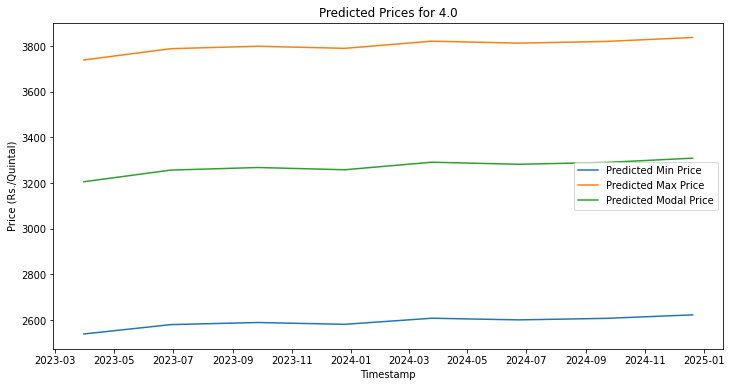

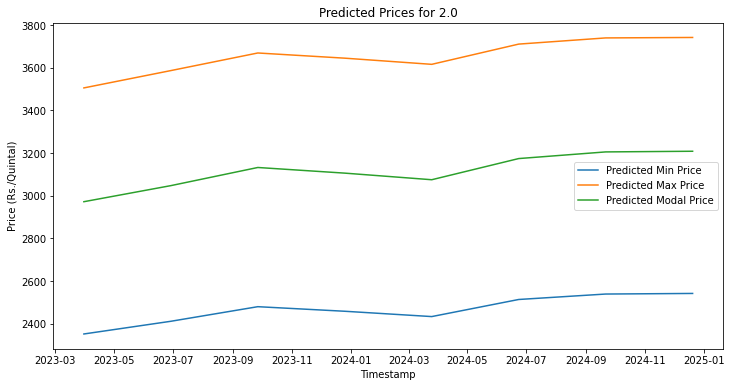

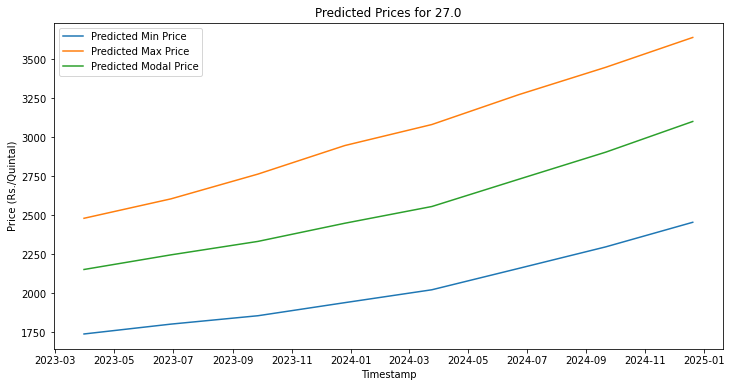

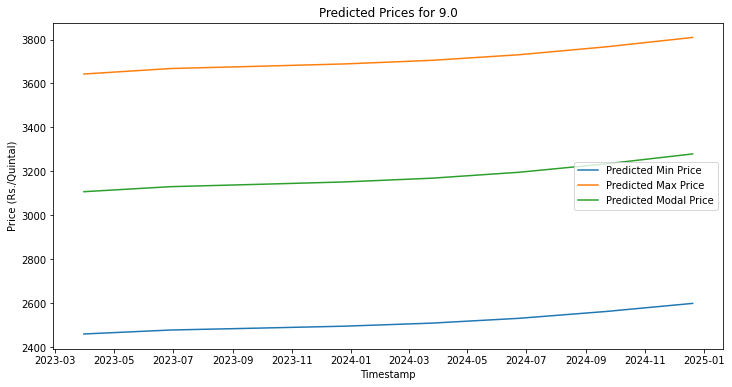

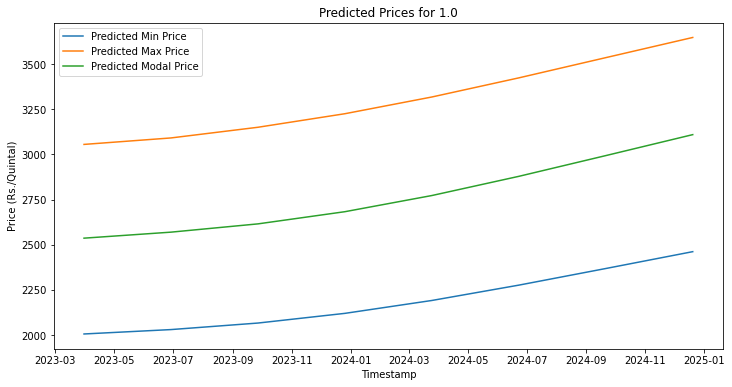

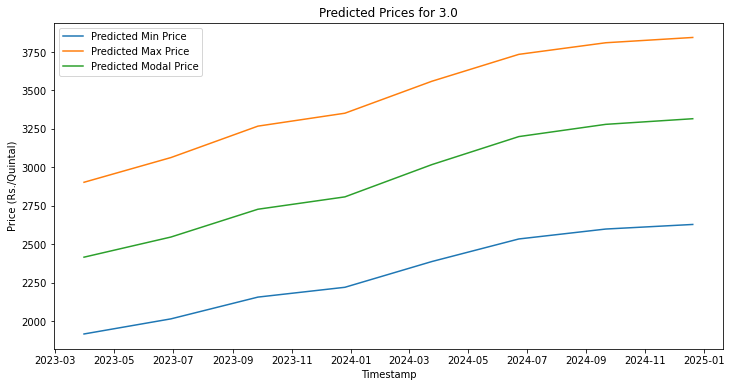

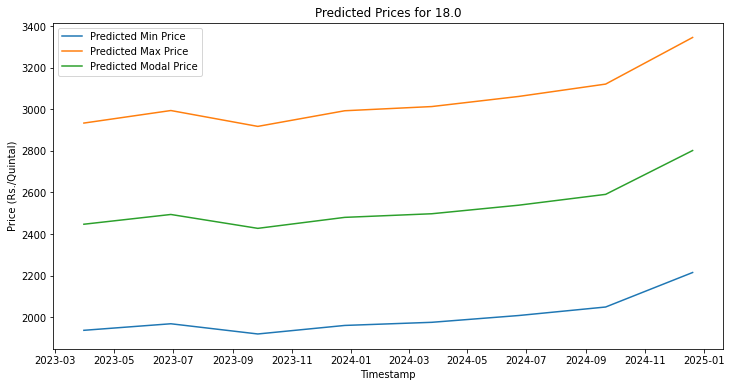

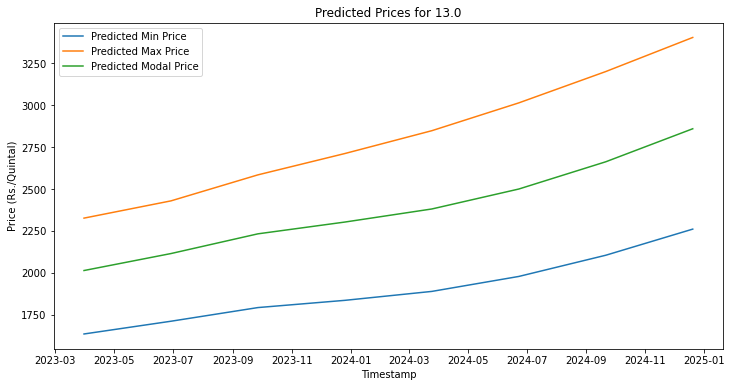

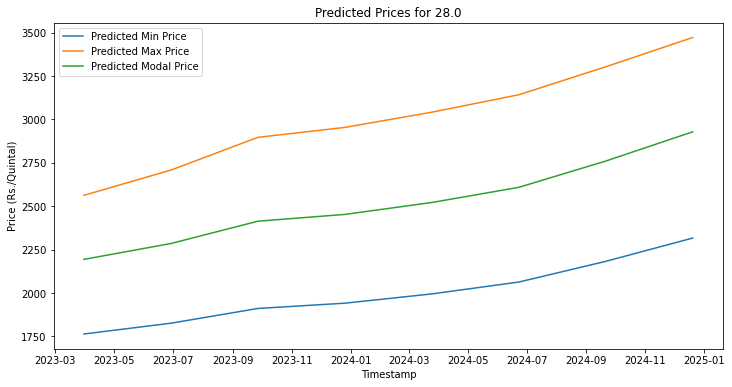

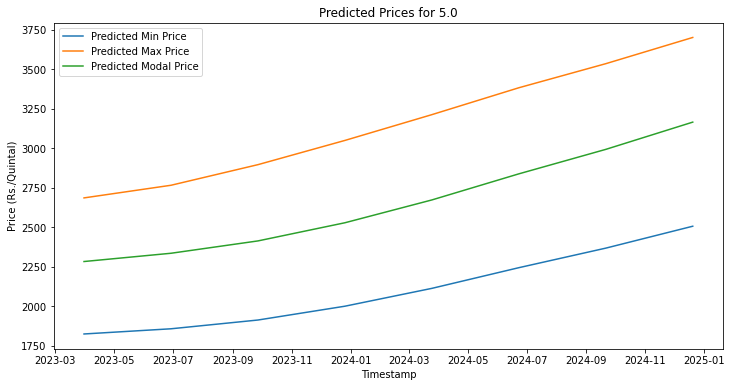

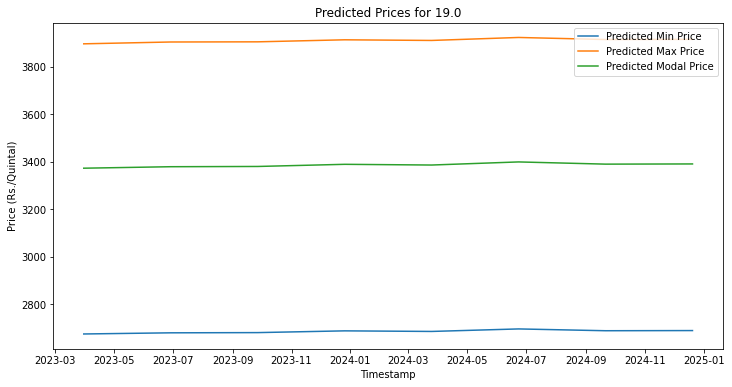

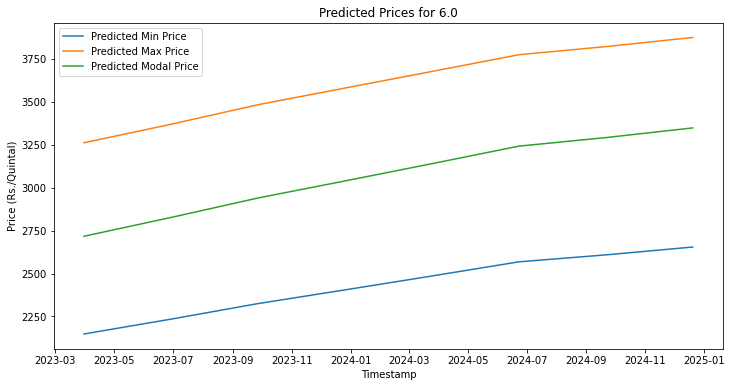

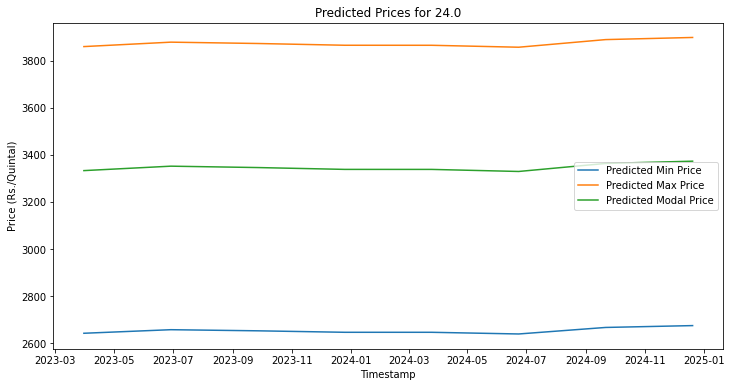

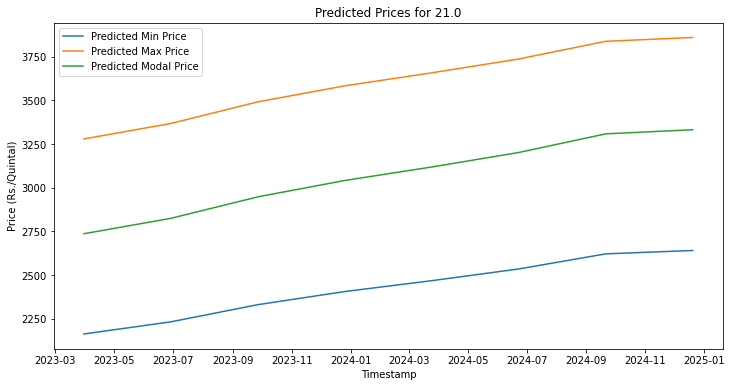

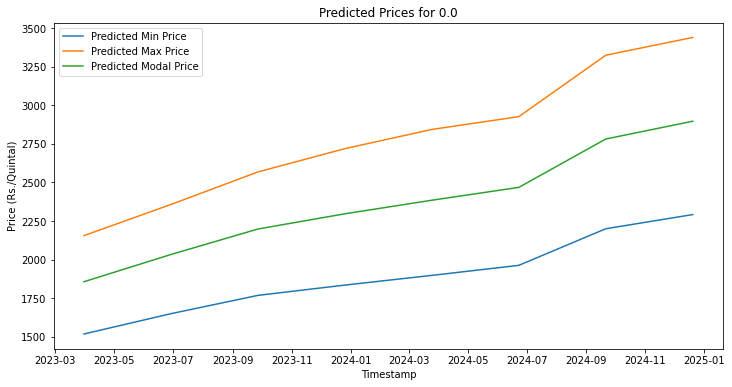

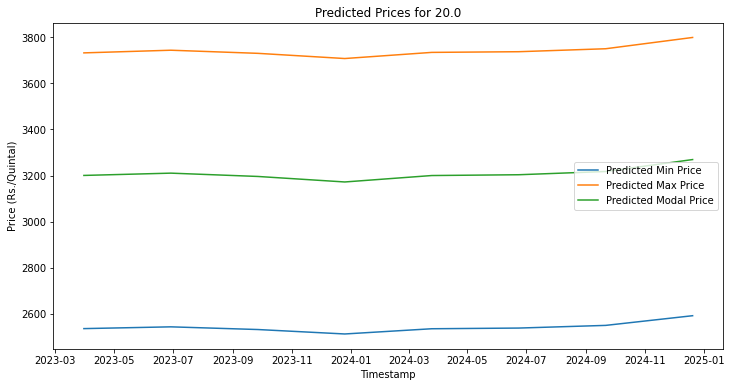

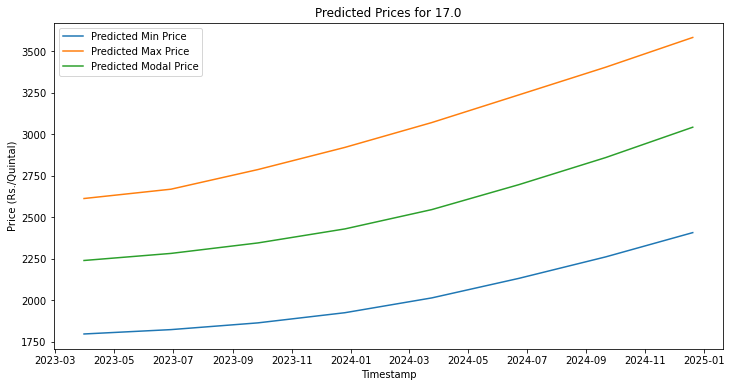

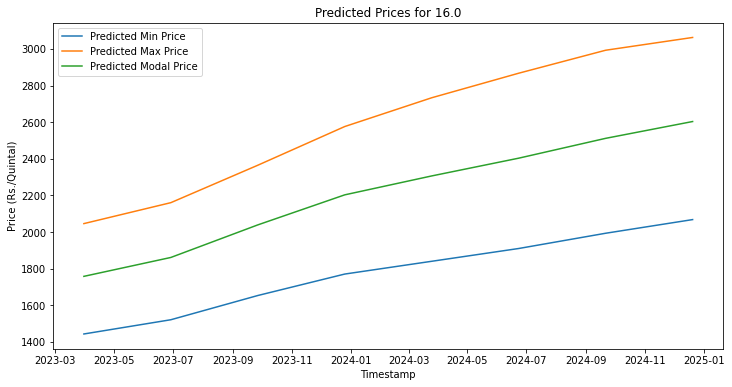

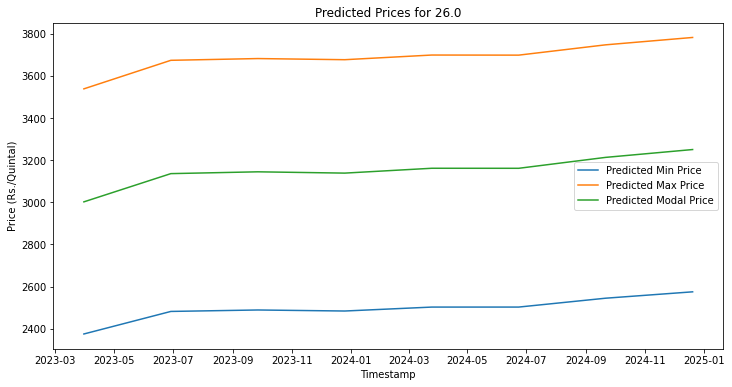

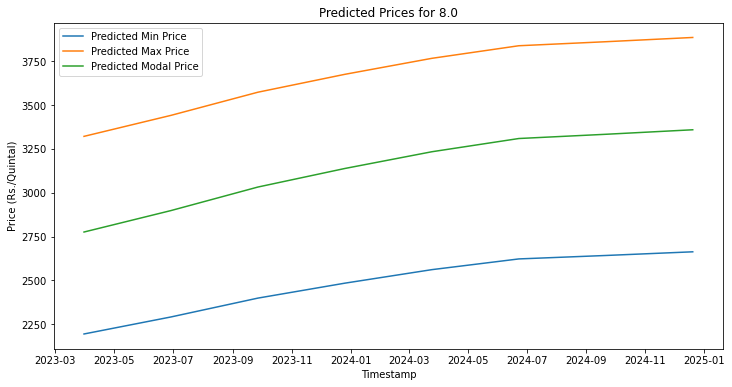

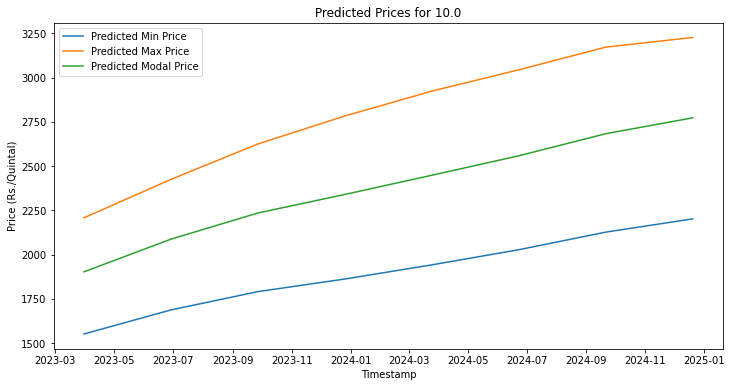

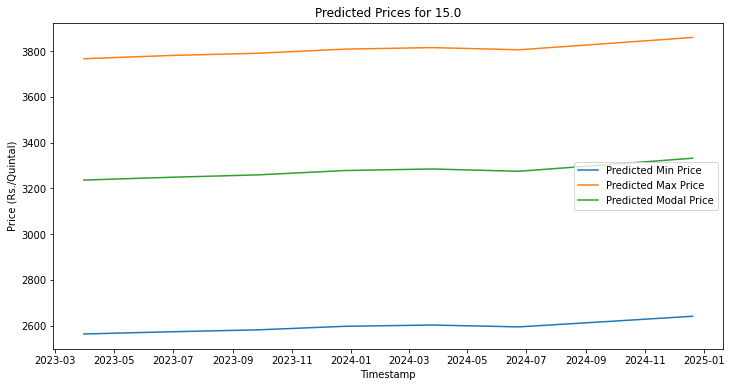

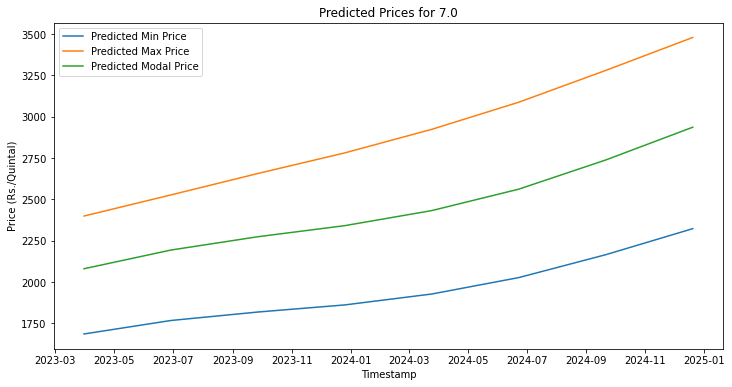

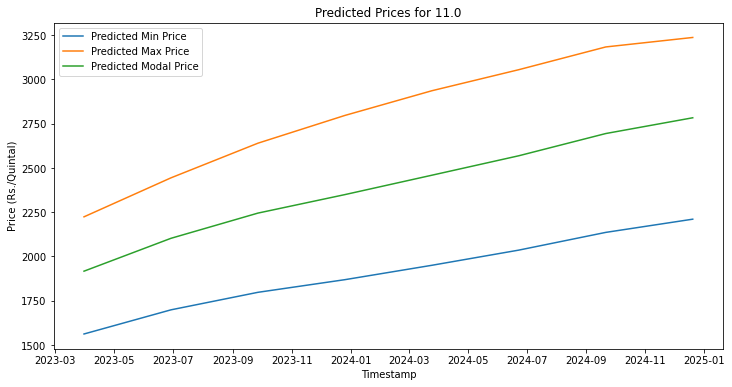

In [108]:
import matplotlib.pyplot as plt

# Assuming 'all_predictions_df' contains your predicted prices DataFrame

# Iterate over unique Market Names
for market_name in all_predictions_df['Market_Name'].unique():
    # Filter the DataFrame for the specific market
    market_data = all_predictions_df[all_predictions_df['Market_Name'] == market_name]

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(market_data['Timestamp'], market_data['Predicted Min Price'], label='Predicted Min Price')
    plt.plot(market_data['Timestamp'], market_data['Predicted Max Price'], label='Predicted Max Price')
    plt.plot(market_data['Timestamp'], market_data['Predicted Modal Price'], label='Predicted Modal Price')
    
    plt.title(f'Predicted Prices for {market_name}')
    plt.xlabel('Timestamp')
    plt.ylabel('Price (Rs./Quintal)')
    plt.legend()
    plt.show()


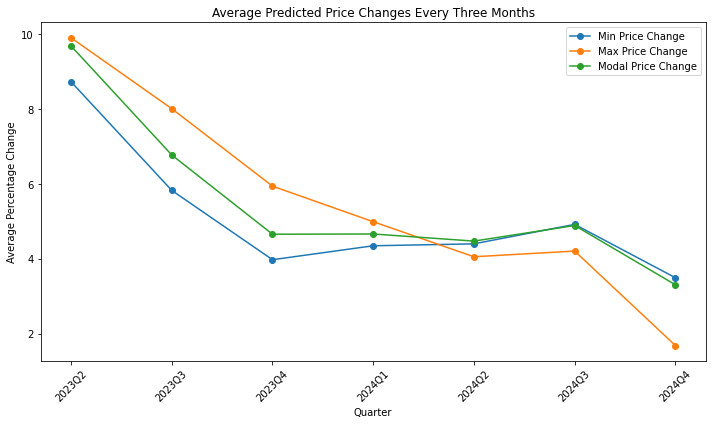

In [109]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named 'predicted_prices_df' with columns 'Timestamp', 'Predicted Min Price', 'Predicted Max Price', 'Predicted Modal Price'
# Replace these column names accordingly if they are different in your case.

# Calculate percentage change
future_prices_df['Min Price Change'] = future_prices_df['Predicted Min Price'].pct_change() * 100
future_prices_df['Max Price Change'] = future_prices_df['Predicted Max Price'].pct_change() * 100
future_prices_df['Modal Price Change'] = future_prices_df['Predicted Modal Price'].pct_change() * 100

# Group by three-month intervals
future_prices_df['Quarter'] = future_prices_df['Timestamp'].dt.to_period("Q")
grouped_df = future_prices_df.groupby('Quarter').mean()

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(grouped_df.index.astype(str), grouped_df['Min Price Change'], label='Min Price Change', marker='o')
plt.plot(grouped_df.index.astype(str), grouped_df['Max Price Change'], label='Max Price Change', marker='o')
plt.plot(grouped_df.index.astype(str), grouped_df['Modal Price Change'], label='Modal Price Change', marker='o')

plt.title('Average Predicted Price Changes Every Three Months')
plt.xlabel('Quarter')
plt.ylabel('Average Percentage Change')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
